# Predicting Health Charges

#### Chris Richards
#### Practicum 1, Summer 2020
#### Regis University

### GridSearchCV with XGBoost Regression

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import graphviz

from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split

import xgboost as xgb

In [32]:
df = pd.read_csv(r"E:\Regis\Practicum_1\df_2_all_features.csv")
df_profile = df

In [33]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1337 non-null   int64  
 1   bmi               1337 non-null   float64
 2   children          1337 non-null   int64  
 3   charges           1337 non-null   float64
 4   sex_female        1337 non-null   int64  
 5   sex_male          1337 non-null   int64  
 6   smoker_no         1337 non-null   int64  
 7   smoker_yes        1337 non-null   int64  
 8   region_northeast  1337 non-null   int64  
 9   region_northwest  1337 non-null   int64  
 10  region_southeast  1337 non-null   int64  
 11  region_southwest  1337 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 125.5 KB
None
               age          bmi     children       charges   sex_female  \
count  1337.000000  1337.000000  1337.000000   1337.000000  1337.000000   
mean     39.222139    30.66

#### Split the data into the test and train sets
The test size is set to 30% of the set.  A random seed of 1179 is set for reproducibility.  

In [34]:
#X = df.filter(items=['age', 'bmi', 'smoker_no', 'smoker_yes'])
X = df.loc[:, df.columns != 'charges'] # select all columns except for charges
y = df['charges']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1179)

In [36]:
X_train

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
171,49,30.300,0,0,1,1,0,0,0,0,1
395,46,19.855,0,0,1,1,0,0,1,0,0
408,38,21.120,3,0,1,1,0,0,0,1,0
1238,25,42.130,1,1,0,1,0,0,0,1,0
76,29,29.590,1,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1118,30,19.950,3,1,0,1,0,0,1,0,0
914,24,33.990,0,1,0,1,0,0,0,1,0
825,56,31.790,2,0,1,0,1,0,0,1,0
928,41,34.210,1,0,1,1,0,0,0,1,0


In [37]:
y_train

171      8116.68000
395      7526.70645
408      6652.52880
1238     3238.43570
76       3947.41310
           ...     
1118     5693.43050
914      2473.33410
825     43813.86610
928      6289.75490
655      3410.32400
Name: charges, Length: 935, dtype: float64

In [38]:
X_test

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
410,19,17.480,0,0,1,1,0,0,1,0,0
1264,64,23.760,0,0,1,0,1,0,0,1,0
454,32,46.530,2,0,1,1,0,0,0,1,0
781,51,35.970,1,0,1,1,0,0,0,1,0
279,51,21.560,1,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
48,60,24.530,0,1,0,1,0,0,0,1,0
631,29,35.530,0,1,0,1,0,0,0,1,0
290,28,33.400,0,1,0,1,0,0,0,0,1
368,44,32.015,2,0,1,1,0,0,1,0,0


In [39]:
y_test

410      1621.34020
1264    26926.51440
454      4686.38870
781      9386.16130
279      9855.13140
           ...     
48      12629.89670
631      3366.66970
290      3172.01800
368      8116.26885
581      6356.27070
Name: charges, Length: 402, dtype: float64

#### GridSearchCV
   
Create XGBoost model

In [41]:
xg_model = xgb.XGBRegressor() 

Create list of parameters

In [42]:
candidate_parameters = {
    'objective': ['reg:squarederror'],
    'seed': ['1970'],
    'colsample_bytree': [0.1, 0.25, 0.5, 0.75], 
    'learning_rate': [0.1, 0.25, 0.5, 0.75], 
    'max_depth': [3, 5, 8, 10, 15, 20],
    'alpha': [1, 5, 10],
    'gamma': [1, 5, 10],
    'lambda': [1, 5, 10],
    'n_estimators': [5, 10, 20, 50, 100, 1000], 
    #'eval_metric':['rmse'],
    'min_child_weight': [0, 1, 2, 3]
}

Create gridsearch

In [43]:
gs = GridSearchCV(
    estimator=xg_model,
    cv=10,
    param_grid=candidate_parameters,
    scoring='r2',
    n_jobs=-1
)

Fit gridsearch  
WARNING: This process takes many hours (~10hrs) to complete!

In [44]:
gs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estim...
             param_grid={'alpha': [1, 5, 10],
                         'colsample_bytree': [0.1, 0.25, 0.5, 0.75],
                         'gamma': [1, 5, 10], 'lambda': [1, 5, 10],
                         'learning_rate': [0.1, 0.25, 0.5, 0.75],
                         'max_depth': [3, 5

Get best parameters

In [52]:
gs_best_params = gs.best_params_
gs_best_params

{'alpha': 1,
 'colsample_bytree': 0.75,
 'gamma': 1,
 'lambda': 5,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 2,
 'n_estimators': 50,
 'objective': 'reg:squarederror',
 'seed': '1970'}

Get best score

In [53]:
score = (gs.best_score_)*100
f"Accuracy (R^2): {score:.2f}%"

'Accuracy (R^2): 85.56%'

Get best estimator

In [55]:
gs_best_estimator = gs.best_estimator_
gs_best_estimator

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.75, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='', lambda=5,
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=1970, reg_alpha=1,
             reg_lambda=5, scale_pos_weight=1, seed='1970', subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

#### Get results
Store the results of the model fitting

In [71]:
gs_results = gs.cv_results_

Predict test data
THIS DOESN'T MAKE SENSE.  GRIDSEARCHCV SHOULD GET THE WHOLE DATA SET.  THERE IS NO TRAIN/TEST SPLIT

In [100]:
gs_predicts = gs.predict(X_test)


#### XGBoost Best Model
  
Fit the model using best parameters

In [79]:
fit_gs = gs_best_estimator.fit(X_train,y_train)
gs_preds = fit_gs.predict(X_test)

In [80]:
score = fit_gs.score(X_train, y_train)*100
f"Accuracy (R^2) Model 2 training: {score:.2f}%"

'Accuracy (R^2) Model 2 training: 88.48%'

In [82]:
score = fit_gs.score(X_test, gs_preds)*100
f"Accuracy (R^2) Model 2 testing: {score:.2f}%"

'Accuracy (R^2) Model 2 testing: 100.00%'

In [83]:
mse = mean_squared_error(gs_preds, y_test)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % np.sqrt(mse))

MSE: 20788719.68
RMSE: 4559.46


### Save the model to a file

In [58]:
from sklearn.externals import joblib 

C:\Users\cr117\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [84]:
# Save the model as a pickle in a file 
joblib.dump(fit_gs, 'gscv_xgb_model.pkl') 
  
# Load the model from the file 
fit_gs_model_from_joblib = joblib.load('gscv_xgb_model.pkl')  
  
# Use the loaded model to make predictions 
fit_gs_model_from_joblib.predict(X_test) 

array([ 2049.3755, 26286.9   ,  6969.161 , 11276.808 , 10925.098 ,
       10284.823 , 12097.95  , 11898.742 ,  4941.643 ,  8051.032 ,
       25488.623 , 28706.12  , 40694.06  ,  6438.3774, 10693.589 ,
        4484.9985, 11661.409 ,  9436.869 ,  7453.5166, 12927.556 ,
        8502.56  ,  9677.094 , 12659.448 , 22343.86  ,  3925.1377,
        7453.5166,  3847.8542, 24553.547 , 40172.043 ,  7698.321 ,
        6507.917 ,  9436.869 , 35226.004 , 37457.89  , 12425.669 ,
        5366.062 ,  5060.5693,  4725.2056,  7609.7026,  3699.3389,
        5491.4116, 12288.745 ,  9604.332 ,  4976.5303, 25084.354 ,
        6238.6724, 38281.887 ,  3734.9624,  9418.351 ,  7698.321 ,
       12197.182 , 12369.897 ,  8582.476 ,  3925.1377, 13692.102 ,
        8047.375 , 12827.782 , 14865.471 ,  5219.0986, 44846.94  ,
       40192.215 , 10434.175 ,  4948.535 , 10015.074 ,  6669.368 ,
        8409.268 , 37730.344 ,  7698.1978,  6338.399 ,  9663.643 ,
       16015.893 ,  6625.06  , 42862.066 , 13701.29  , 18155.4

### Save as json file

In [85]:
fit_gs.save_model('gscv_xgb_model.json')

#### Model 2: Plots

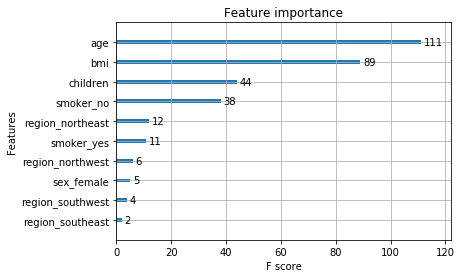

In [86]:
xgb.plot_importance(fit_gs)

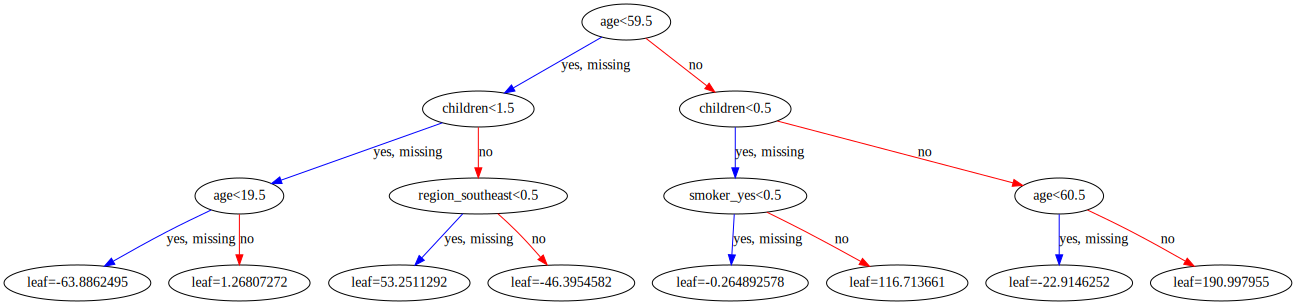

In [88]:
xgb.to_graphviz(fit_gs, num_trees=49)

#### Test out a prediction

In [92]:
# get max charge row
max_charge_row = df.loc[df['bmi'].idxmax()]
max_charge_row

age                   18.0000
bmi                   53.1300
children               0.0000
charges             1163.4627
sex_female             0.0000
sex_male               1.0000
smoker_no              1.0000
smoker_yes             0.0000
region_northeast       0.0000
region_northwest       0.0000
region_southeast       1.0000
region_southwest       0.0000
Name: 1316, dtype: float64

Create new test record similar to max charge record

In [93]:
new_rec_df = pd.DataFrame(max_charge_row)

In [94]:
new_rec_2_df = new_rec_df.transpose()
new_rec_2_df = new_rec_2_df.loc[:, new_rec_2_df.columns != 'charges']

In [ ]:
new_rec_2_df.at[1316, 'age'] = 18
new_rec_2_df.at[1316, 'bmi'] = 53

In [95]:
new_rec_2_df

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
1316,18.0,53.13,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


Predict on the new record

In [96]:
new_pred = fit_gs.predict(new_rec_2_df)

In [97]:
new_pred

array([1553.4713], dtype=float32)